# Author Disambiguation by Clustering & Community Detection Approach

## Author: Mitodru Niyogi

In [66]:
import os
import xml.etree.ElementTree as ET
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances


from src.preprocess import extract_article_title_xml, extract_bibliography_of_article, standardize_author_names
from src.preprocess import extract_all_cited_authors_of_paper, preprocess_author_names_article

# Define the directory path containing the A++ files
#dir_path = '/path/to/folder/containing/xml/files'
dir_path = '../test-articles/'

In [2]:
# Loading A++ data
articles = []

for i in range(1, 51):
    file_name = f'{dir_path}/article-{i}.xml'
    tree = ET.parse(file_name)
    root = tree.getroot()
    articles.append(root)

In [45]:
authors, titles, bibliography =[], [], []
cited_authors_dict = {}
# appending the titles, authors, and ref authors
for article in articles:
    title = extract_article_title_xml(article)
    author = preprocess_author_names_article(article)
    bib, cited_authors_dict = extract_bibliography_of_article(article)
    titles.append(title)
    bibliography.append(bib)
    authors.append(author)
    

In [ ]:
cited_authors_dict

In [48]:
# p is a list where each index contains the names of all ref authors cited in the article
p = extract_all_cited_authors_of_paper(bibliography)

In [50]:
# Vectorize author, article, and bibliography information using TF-IDF
vectorizer = TfidfVectorizer()
author_vectors = vectorizer.fit_transform([" ".join(author_list) for author_list in authors])
title_vectors = vectorizer.fit_transform(titles)
bib_vectors = vectorizer.fit_transform([" ".join(bib_list) for bib_list in p])

In [51]:
print(author_vectors.shape)
print(title_vectors.shape)
print(bib_vectors.shape)

(50, 182)
(50, 418)
(50, 5069)


In [56]:
# concatating the various TF_IDF matrix
author_feature = author_vectors.toarray()
title_feature = title_vectors.toarray()
bib_feature = bib_vectors.toarray()
author_title_feature = np.concatenate((author_feature, title_feature), axis=1)

author_title_bib_feature = np.concatenate((author_title_feature, bib_feature), axis=1)

In [57]:
auth_title_bib_feature.shape

(50, 5669)

In [67]:
def TSNE_plot(features, clusters, authors):    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(features)
    
    # Plot the points and color them according to their assigned cluster labels
    fig, ax = plt.subplots(figsize=(20,20))
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='rainbow')
    # Add legends
    legend1 = ax.legend(*scatter.legend_elements(),loc="best", title="Clusters")
    
    ax.add_artist(legend1)
    l = [" ".join(author_list) for author_list in authors]
    # Display author names along with the cluster label
    for i, txt in enumerate(l):
        ax.annotate(txt, (X_tsne[i,0], X_tsne[i,1]))
        
    plt.show()


## K-Means Clustering
For author disambiguation

/home/mitodru/Documents/interviews/springer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mitodru/Documents/interviews/springer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mitodru/Documents/interviews/springer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mitodru/Documents/interviews/springer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

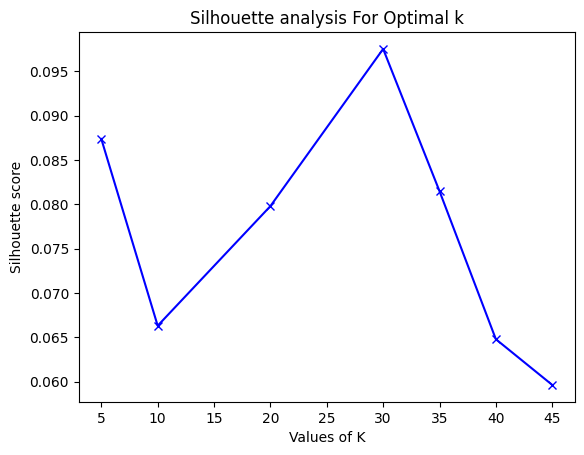

In [72]:
range_n_clusters = [5, 10, 20, 30, 35, 40, 45]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(auth_title_bib_feature)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(author_title_bib_feature, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
    
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [73]:
# Apply K-Means clustering to the feature matrix
kmeans = KMeans(n_clusters=30, random_state=42)
clusters = kmeans.fit_predict(auth_title_bib_feature)

# Evaluate the clustering results using Silhouette score
silhouette_avg = silhouette_score(author_title_bib_feature, clusters)
print("Silhouette score:", silhouette_avg)

cluster_labels = kmeans.labels_

/home/mitodru/Documents/interviews/springer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.06754950568938548


In [76]:
# Output results
for i, label in enumerate(cluster_labels):
    print(f"Article {i+1} authors:")
    print(authors[i])
    print(f"Cluster label: {label}\n")

Article 1 authors:
['anita brandstätter', 'rachel klein', 'nina duftner', 'peter wiegand', 'walther parson']
Cluster label: 9

Article 2 authors:
['i. a. tsekmes', 'p. h. f. morshuis', 'j. j. smit', 'r. kochetov']
Cluster label: 16

Article 3 authors:
['m dutta choudhury', 's tarafdar']
Cluster label: 12

Article 4 authors:
['joost j smit', 'maarten t pennings', 'karina willemsen', 'manon van roest', 'els van hoffen', 'raymond h pieters']
Cluster label: 2

Article 5 authors:
['joost j smit', 'maarten t pennings', 'karina willemsen', 'manon van roest', 'els van hoffen', 'raymond h pieters']
Cluster label: 2

Article 6 authors:
['p. gal', 'j. j. j. smit', 'a. adiyaman', 'a. r. ramdat misier', 'p. p. h. m. delnoy', 'a. elvan']
Cluster label: 18

Article 7 authors:
['a. ghani', 'p. p. h. m. delnoy', 'a. r. ramdat misier', 'j. j. j. smit', 'a. adiyaman', 'j. p. ottervanger', 'a. elvan']
Cluster label: 0

Article 8 authors:
['m. i. chumakov']
Cluster label: 17

Article 9 authors:
['luca mode

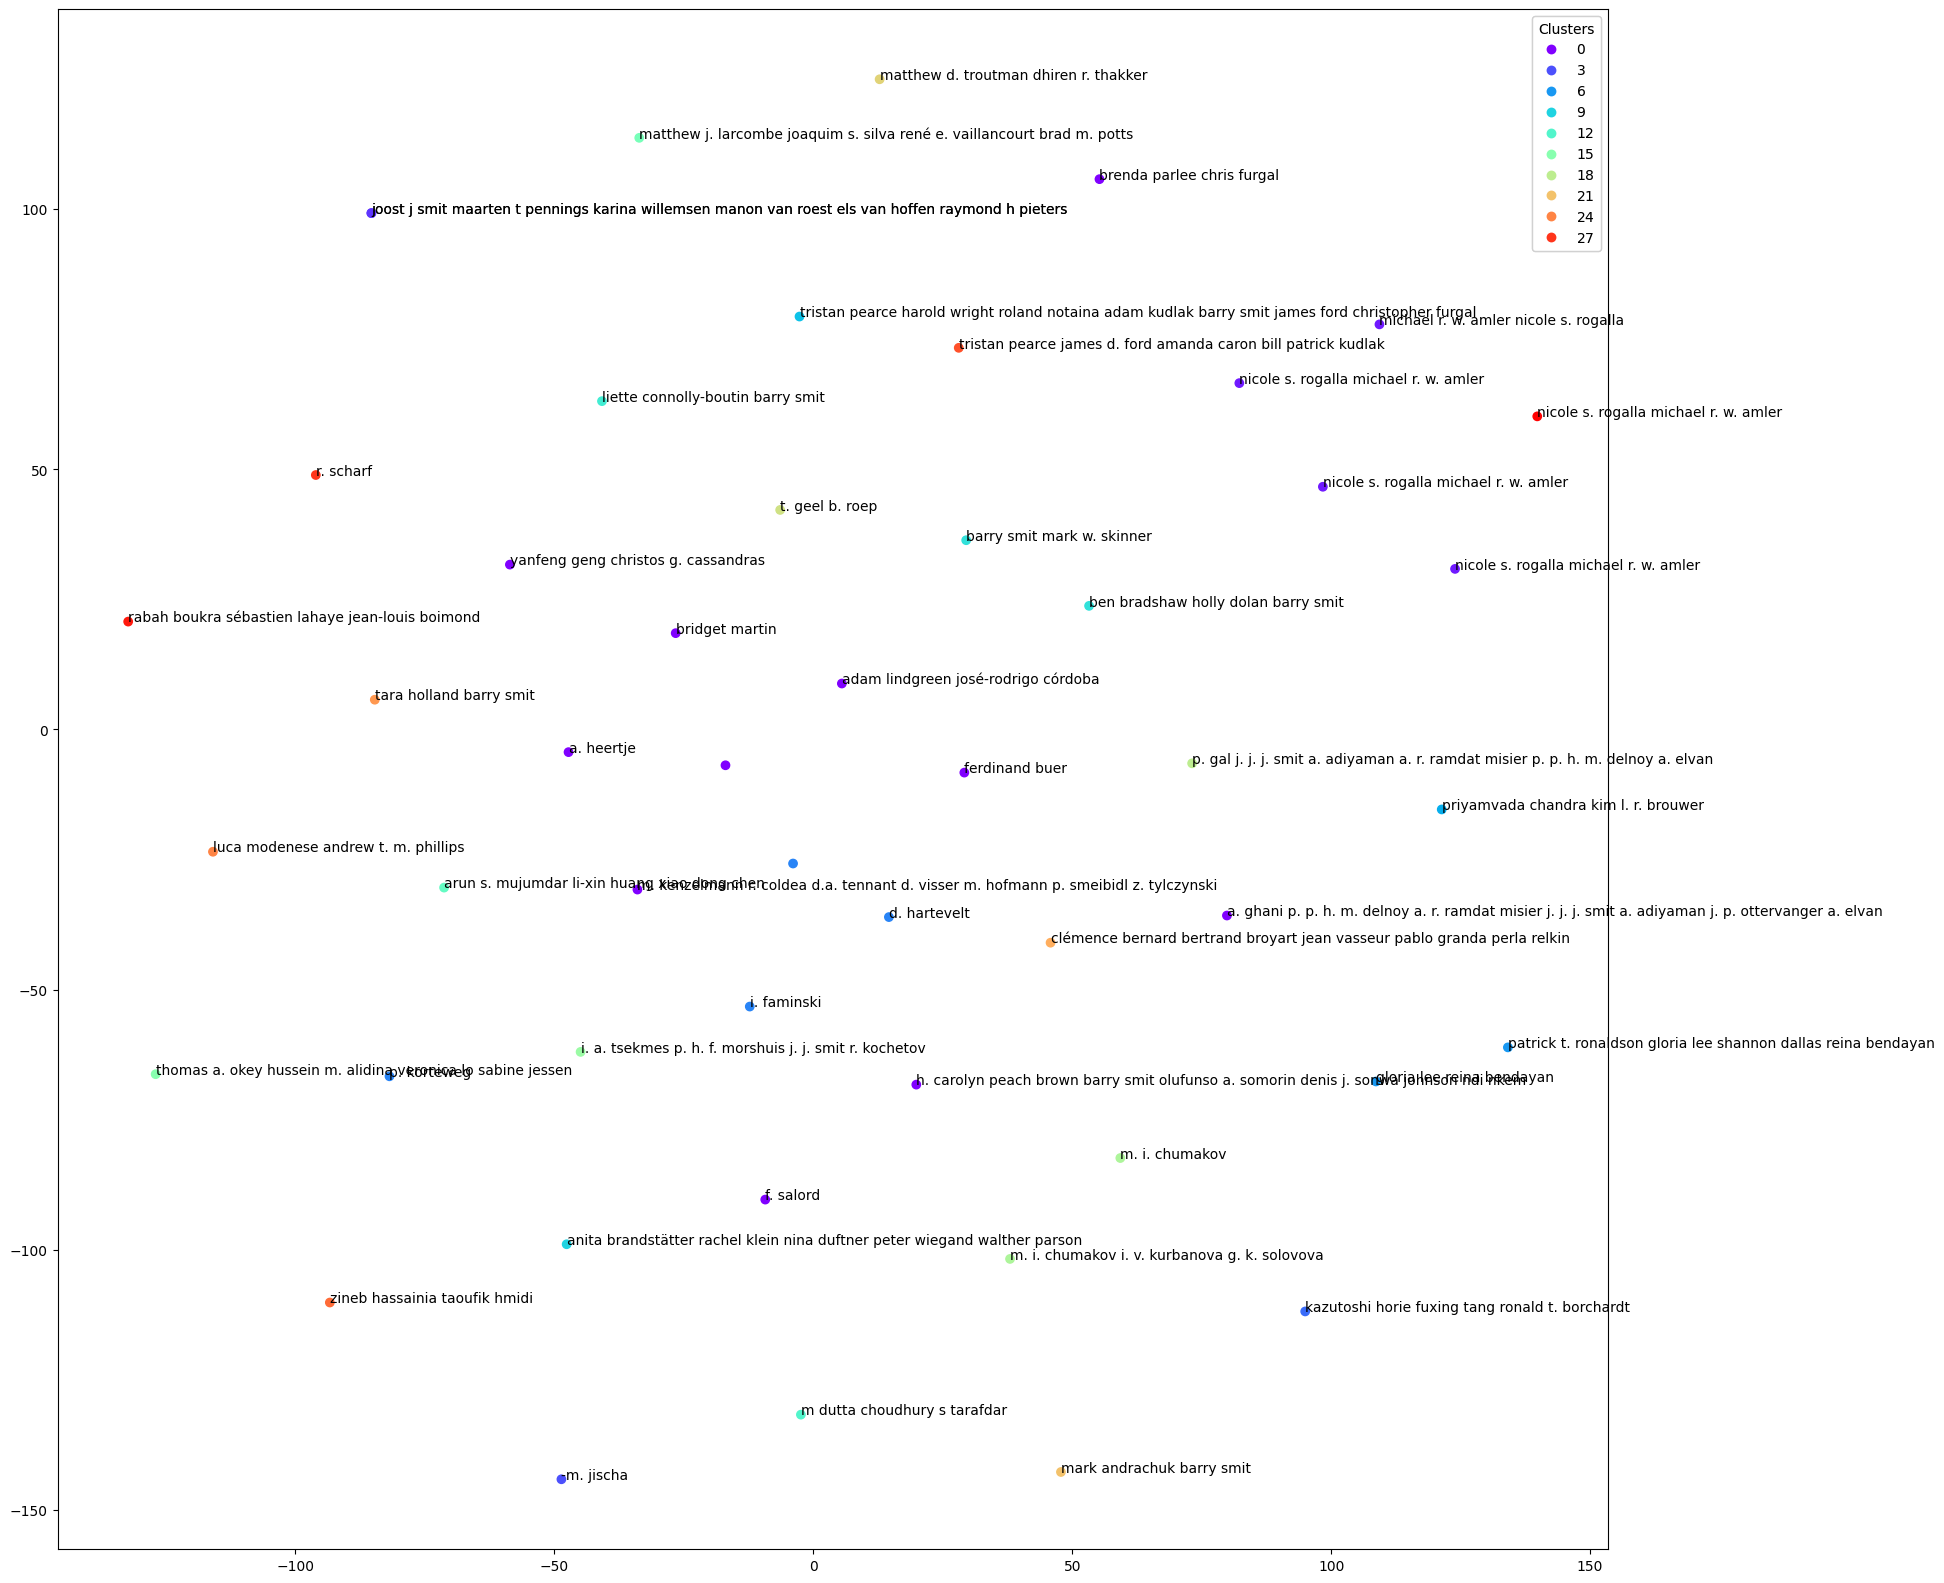

In [75]:
TSNE_plot(author_title_bib_feature, cluster_labels, authors)

## Community detection
Author disambiguation using community detection Louvain algorithm

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_coauthor_graph(author_lists):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes for each author
    for author_list in author_lists:
        G.add_nodes_from(author_list)

    # Add edges between co-authors
    for author_list in author_lists:
        for author1 in author_list:
            for author2 in author_list:
                if author1 != author2:
                    if G.has_edge(author1, author2):
                        G[author1][author2]['weight'] += 1
                    else:
                        G.add_edge(author1, author2, weight=1)

    return G


import community

def detect_communities(G):
    # Louvain algorithm to detect communities
    partition = community.best_partition(G)

    # Create a dictionary where the keys are the community IDs and the values are lists of authors in that community
    communities = {}
    for author, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(author)

    return communities, partition


In [8]:
# Create a graph of co-authors
G = create_coauthor_graph(authors)

# Detect communities
communities, partition = detect_communities(G)

# Print the communities
for community_id, authors in communities.items():
    print(f'Community {community_id}: {authors}')


Community 0: ['anita brandstätter', 'rachel klein', 'nina duftner', 'peter wiegand', 'walther parson']
Community 1: ['i. a. tsekmes', 'p. h. f. morshuis', 'j. j. smit', 'r. kochetov']
Community 2: ['m dutta choudhury', 's tarafdar']
Community 3: ['joost j smit', 'maarten t pennings', 'karina willemsen', 'manon van roest', 'els van hoffen', 'raymond h pieters']
Community 4: ['p. gal', 'j. j. j. smit', 'a. adiyaman', 'a. r. ramdat misier', 'p. p. h. m. delnoy', 'a. elvan', 'a. ghani', 'j. p. ottervanger']
Community 5: ['m. i. chumakov', 'i. v. kurbanova', 'g. k. solovova']
Community 6: ['luca modenese', 'andrew t. m. phillips']
Community 7: ['arun s. mujumdar', 'li-xin huang', 'xiao dong chen']
Community 8: ['clémence bernard', 'bertrand broyart', 'jean vasseur', 'pablo granda', 'perla relkin']
Community 9: ['gloria lee', 'reina bendayan', 'patrick t. ronaldson', 'shannon dallas']
Community 10: ['priyamvada chandra', 'kim l. r. brouwer']
Community 11: ['matthew d. troutman', 'dhiren r. t

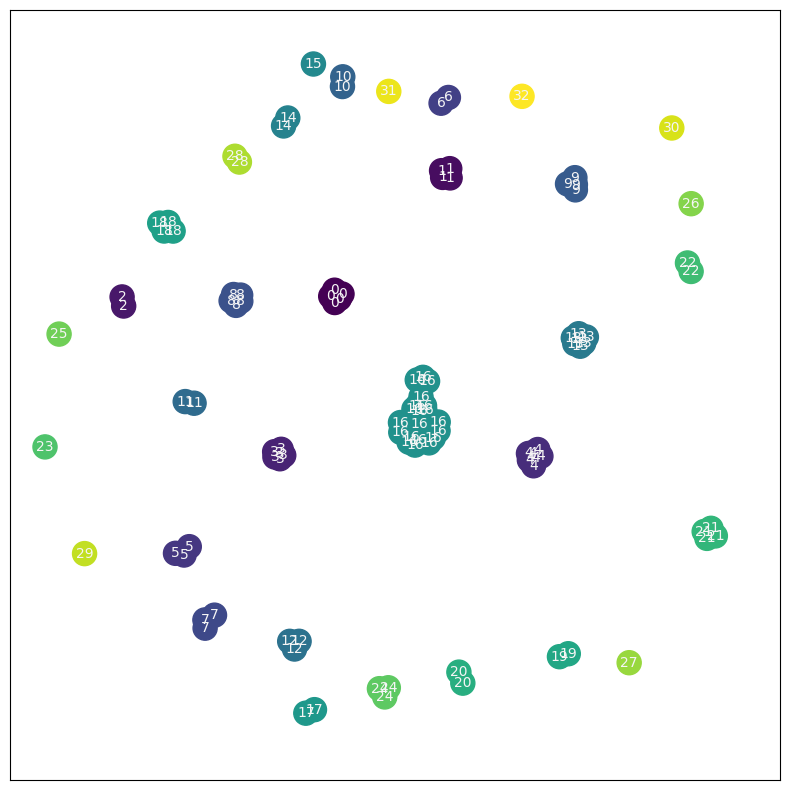

In [39]:
fig = plt.figure("Degree of a random graph", figsize=(8, 8))
node_color=list(partition.values())
# Draw the graph with the community colors
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, partition, font_size=10, font_color="whitesmoke")
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


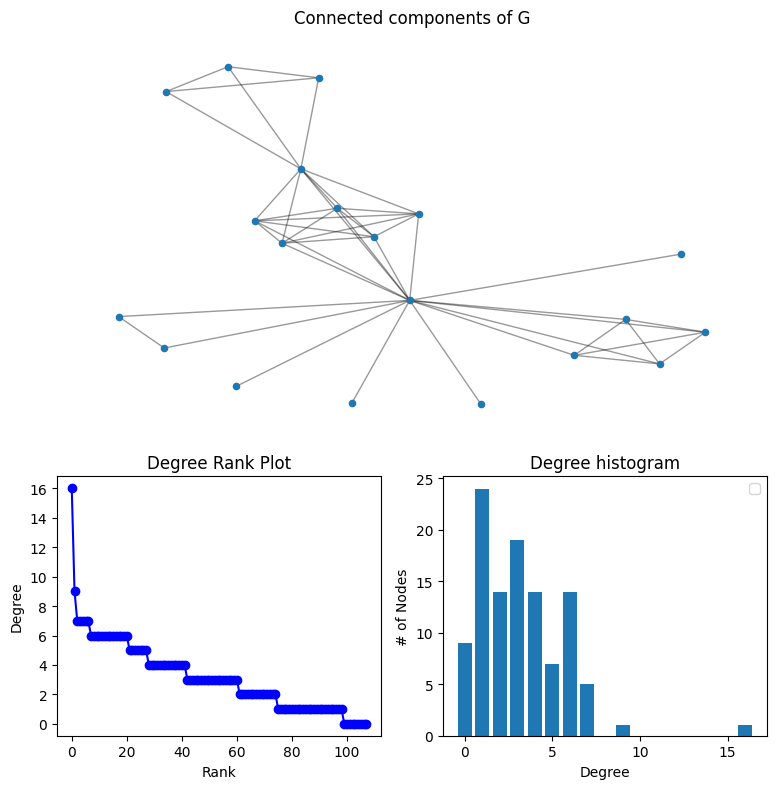

In [37]:
# using the code from https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.legend()
plt.show()